In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import pandas as pd

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
#obtenemos solo 3 categorías por el costo computacional del algoritmo tsne con sklearn
i_t = np.where((train_labels == 1) | (train_labels == 2) | (train_labels == 3))
train_labels_split = train_labels[i_t]
train_images_split = train_images[i_t]

i_te = np.where((test_labels == 1) | (test_labels == 2) | (test_labels == 3))
test_labels_split = test_labels[i_te]
test_images_split = test_images[i_te]

In [5]:
dataset = train_images_split.reshape((-1, 28 * 28)).astype(np.float32)/255.0
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [6]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.cumulative_explained_variance = None
        self.explained_variance_ratio = None
        self.explained_variance = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        cov = np.cov(X.T) #obtener coavarianza
        
        eigenvalues, eigenvectors = np.linalg.eig(cov)#obtener enigenvalues y eigenvectors con numpy
        
        # ordenar eigenvectors
        eigenvectors = eigenvectors.T
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]
        
        # obtener varianza acumulada
        eigenvalues_main = eigenvalues[0:self.n_components]
        self.cumulative_explained_variance = np.cumsum(eigenvalues_main)/np.sum(eigenvalues)
        self.explained_variance_ratio = eigenvalues_main/np.sum(eigenvalues)
        self.explained_variance = eigenvalues_main
        
        # obtener los primeros componentes
        self.components = eigenvectors[0:self.n_components]

    def transform(self, X):
        X = X - self.mean
        return np.dot(X, self.components.T)

In [7]:
model = PCA(2)

In [8]:
model.fit(dataset)

In [9]:
data_new = model.transform(dataset)

In [10]:
varianza_explicada = model.explained_variance
proporcion_varianza_explicada = model.explained_variance_ratio
varianza_acumulada = model.cumulative_explained_variance

print("varianza explicada:",varianza_explicada)
print("proporcion de varianza explicada:",proporcion_varianza_explicada)
print("varianza explicada acumulada:",varianza_acumulada)

varianza explicada: [18.62107237  7.87438004]
proporcion de varianza explicada: [0.35778511 0.15129826]
varianza explicada acumulada: [0.35778511 0.50908337]


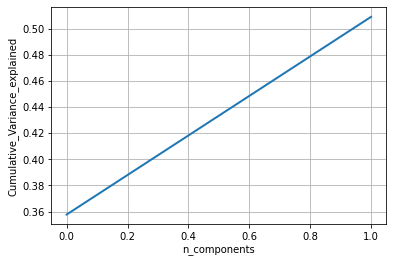

In [11]:
plt.plot(varianza_acumulada,linewidth=2)   
plt.grid() 
plt.xlabel('n_components') 
plt.ylabel('Cumulative_Variance_explained')  
plt.show()

<BarContainer object of 2 artists>

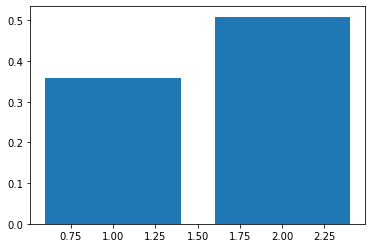

In [12]:
componets = [c for c in range(1,model.n_components+1)]
plt.bar(componets,varianza_acumulada)

In [13]:
from sklearn.manifold import TSNE

In [26]:
model_2 = TSNE(2,random_state=0)

In [27]:
data_new_2 = model_2.fit_transform(dataset)

## Conclusiones

#### PCA
La varianza explicada, al reducir a dos componentes principales es de 50%, lo cual es muy poco ya que buscamos preservar la mayor varianza posible, es probable que necesitemos mas componentes, por el momento a modo de visualización nos quedaremos con 2 componentes.

#### TSNE
Computacionalmente es mucho mas costoso que PCA.


In [28]:
#obtener colores
def getColor(labels):
    colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
    return [colors[int(l)] for l in labels]

In [71]:
#reporte de metricas y visualización del cluster
def report(data,original_labels,algorithm):
    from sklearn.cluster import KMeans
    from sklearn import metrics
    from statistics import mode
    
    ccats = getColor(original_labels)
    
    km = KMeans(3,random_state=1)
    data_km = km.fit_transform(data)    
    
    idx = np.where(original_labels == 1)
    lbl0 = mode(km.labels_[idx])
    
    idx = np.where(original_labels == 2)
    lbl1 = mode(km.labels_[idx])
    
    labels = pd.DataFrame(km.labels_.copy(),columns=['labels'])
    labels["labels"] = np.where(labels['labels']==lbl0, 1, np.where(labels['labels']==lbl1,2,3))
    labels = np.array(labels['labels'])
    
    print("Homogeneidad: %0.3f"%metrics.homogeneity_score(labels, original_labels))
    print("Completitud: %0.3f"%metrics.completeness_score(labels, original_labels))
    print("V-measure: %0.3f"%metrics.v_measure_score(labels, original_labels))
    print("R2 ajustado: %0.3f"%metrics.adjusted_rand_score(labels, original_labels))
    print("Información mútua ajustada: %0.3f"%metrics.adjusted_mutual_info_score(labels, original_labels))
    print("Exactitud: %0.3f"%metrics.accuracy_score(labels,original_labels))
    
    if data.shape[1] == 2:
        fig = plt.figure(figsize=(15,6))
        axarr = fig.subplots(1,2)
        axarr[0].scatter(data[:,0],data[:,1],c=ccats)
        axarr[0].set_xlabel("Componente principal 1")
        axarr[0].set_ylabel("Componente principal 2")
        axarr[0].set_title("Nuevos datos con algoritmo "+algorithm)

        axarr[1].scatter(data[:,0],data[:,1],c=getColor(np.array(labels)))
        axarr[1].scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],marker="x",s=100,c="k")
        axarr[1].set_xlabel("Componente principal 1")
        axarr[1].set_ylabel("Componente principal 2")
        axarr[1].set_title("Datos clusterizados KMeans para datos "+algorithm)

        plt.show()

Homogeneidad: 0.812
Completitud: 0.811
V-measure: 0.811
R2 ajustado: 0.865
Información mútua ajustada: 0.811
Exactitud: 0.953


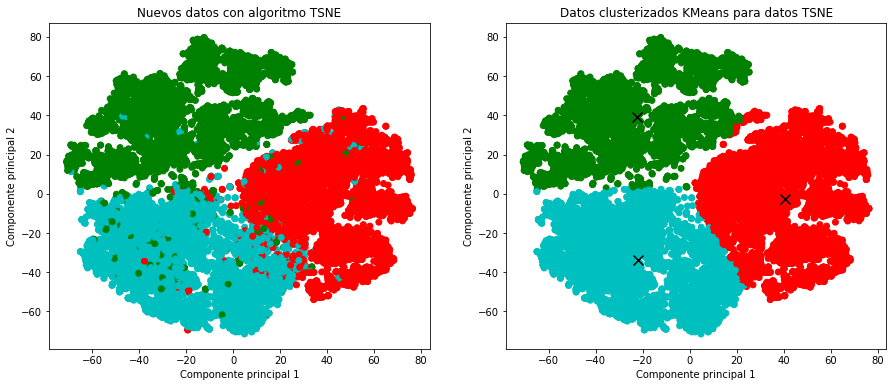

In [72]:
report(data_new_2,train_labels_split,"TSNE")

Homogeneidad: 0.362
Completitud: 0.343
V-measure: 0.352
R2 ajustado: 0.320
Información mútua ajustada: 0.352
Exactitud: 0.581


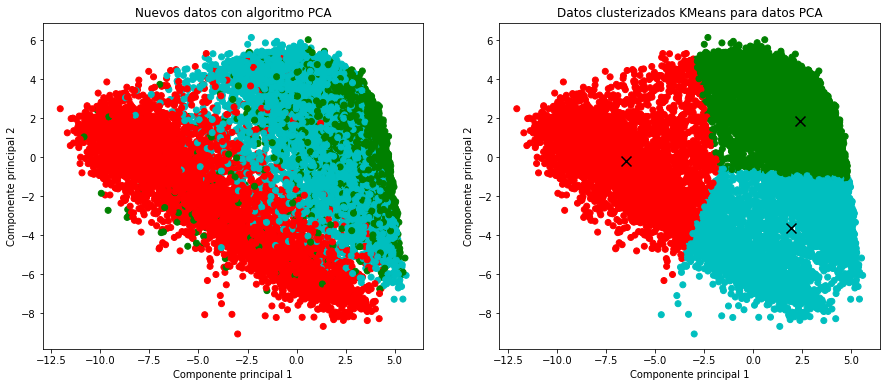

In [73]:
report(data_new,train_labels_split,"PCA")

# Conslusiones finales.

Observamos que TSNE aunque es mucho mas costoso computacionalmente, es mucho mas efectivo que PCA, ya que clasifica mejor los datos, las metricas reflejan la efectividad de TSNE.

Para este ejemplo si queremos reducir a 2 dimensiones el dataset, es mejor el algoritmo de TSNE. ya que las metricas para el algoritmo de PCA son muy bajas ya que como se observó la varianza acumulada bastante baja.

### Probando con caracteristicas

In [74]:
features = [10,20,30,40,50]
for f in features:
    m = PCA(f)
    m.fit(dataset)
    data = m.transform(dataset)
    print("\n",f,"caracteristicas")
    print("varianza explicada acumulada: %0.3f"%m.cumulative_explained_variance[-1],'\n')
    report(data,train_labels_split,"PCA")


 10 caracteristicas
varianza explicada acumulada: 0.745 

Homogeneidad: 0.362
Completitud: 0.346
V-measure: 0.354
R2 ajustado: 0.319
Información mútua ajustada: 0.354
Exactitud: 0.596

 20 caracteristicas
varianza explicada acumulada: 0.815 

Homogeneidad: 0.369
Completitud: 0.350
V-measure: 0.359
R2 ajustado: 0.325
Información mútua ajustada: 0.359
Exactitud: 0.597

 30 caracteristicas
varianza explicada acumulada: 0.856 

Homogeneidad: 0.362
Completitud: 0.345
V-measure: 0.354
R2 ajustado: 0.319
Información mútua ajustada: 0.354
Exactitud: 0.596

 40 caracteristicas
varianza explicada acumulada: 0.882 

Homogeneidad: 0.369
Completitud: 0.350
V-measure: 0.359
R2 ajustado: 0.324
Información mútua ajustada: 0.359
Exactitud: 0.597

 50 caracteristicas
varianza explicada acumulada: 0.900 

Homogeneidad: 0.366
Completitud: 0.348
V-measure: 0.357
R2 ajustado: 0.322
Información mútua ajustada: 0.356
Exactitud: 0.596


Las metricas siguen siendo malas aún cuando la varianza preservada es del 88%, es probable que KMeans no sea el tipo clustering apropiado para clasificación de estos datos.

In [75]:
import os
import sys
os.path.dirname(sys.executable)

'C:\\ProgramData\\Anaconda3'